In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import scipy
from matplotlib import rcParams
import matplotlib.pyplot as plt
import sys
from sklearn import metrics
import gc
sys.path.append('../../../Software/mvTCR')
import tcr_embedding.utils_training as utils
rcParams['figure.figsize'] = (8, 4)


In [2]:
# data = sc.read_h5ad('fig2_haniffa_lv.h5ad')
data = sc.read_h5ad('../results/fig2_haniffa_lv.h5ad')
data.obs.clonotype = data.obs.clonotype.astype(str)

# Distribution of important signals

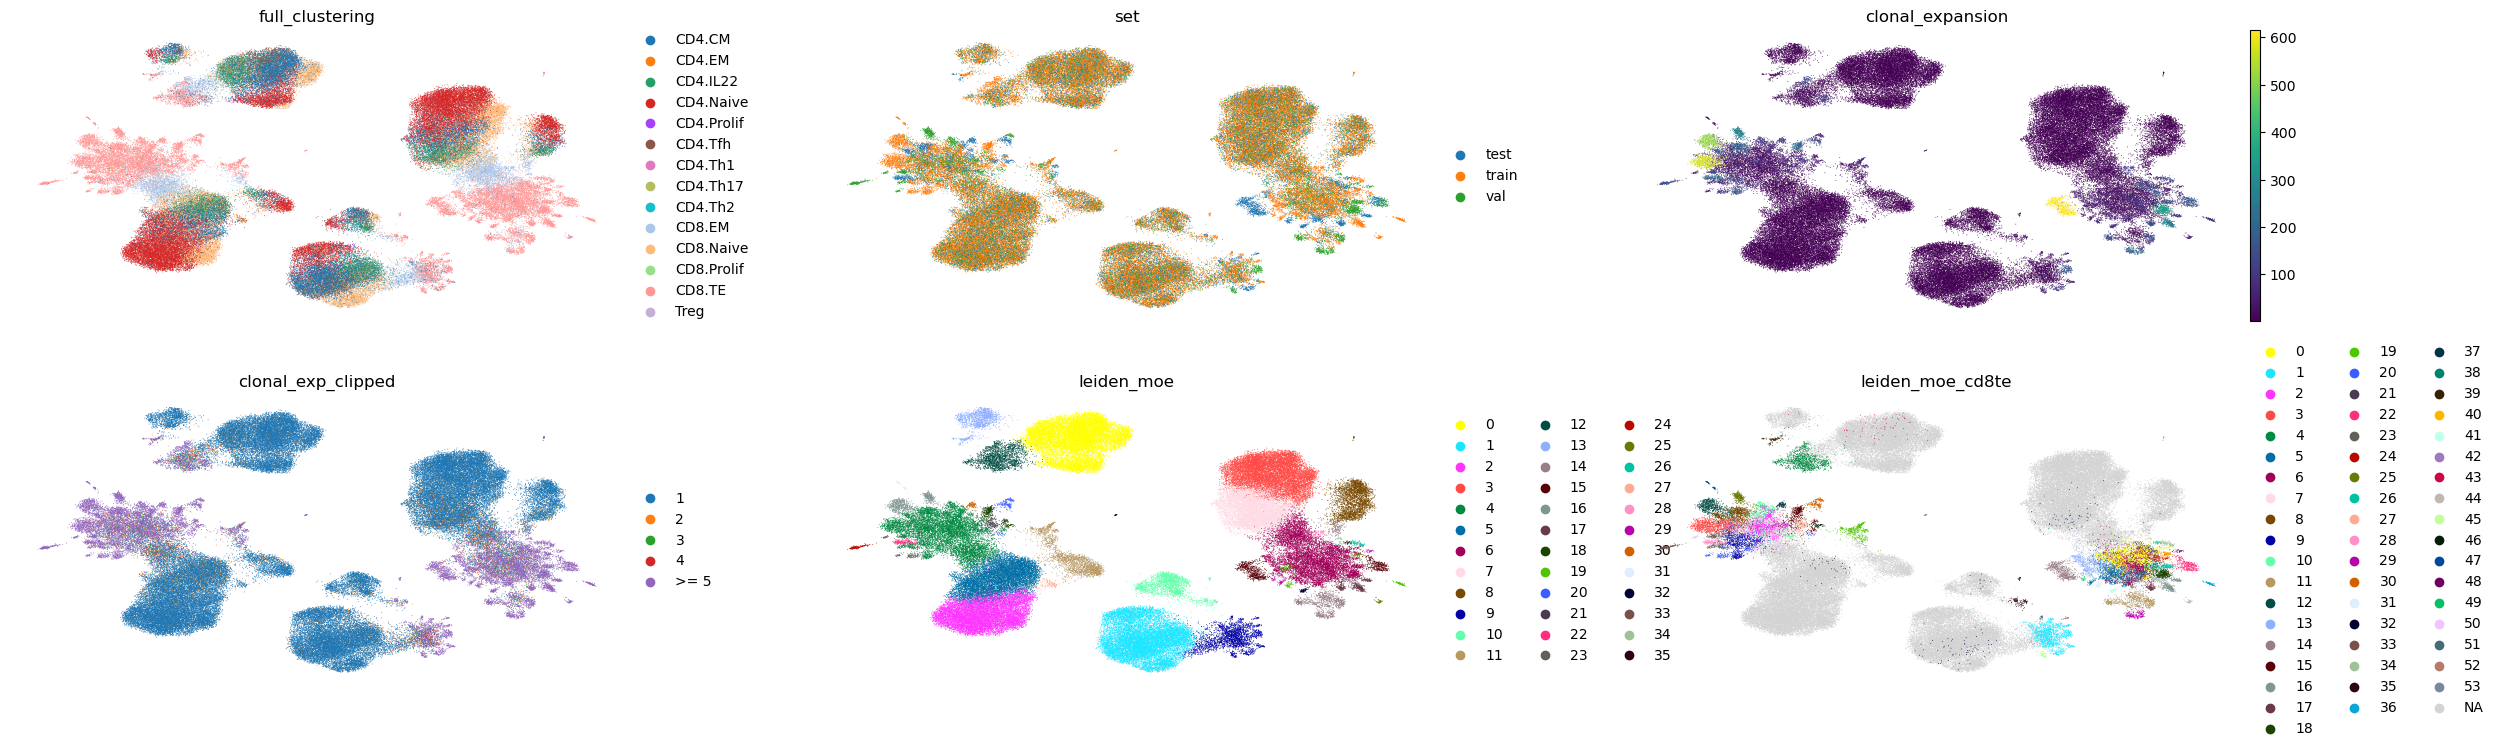

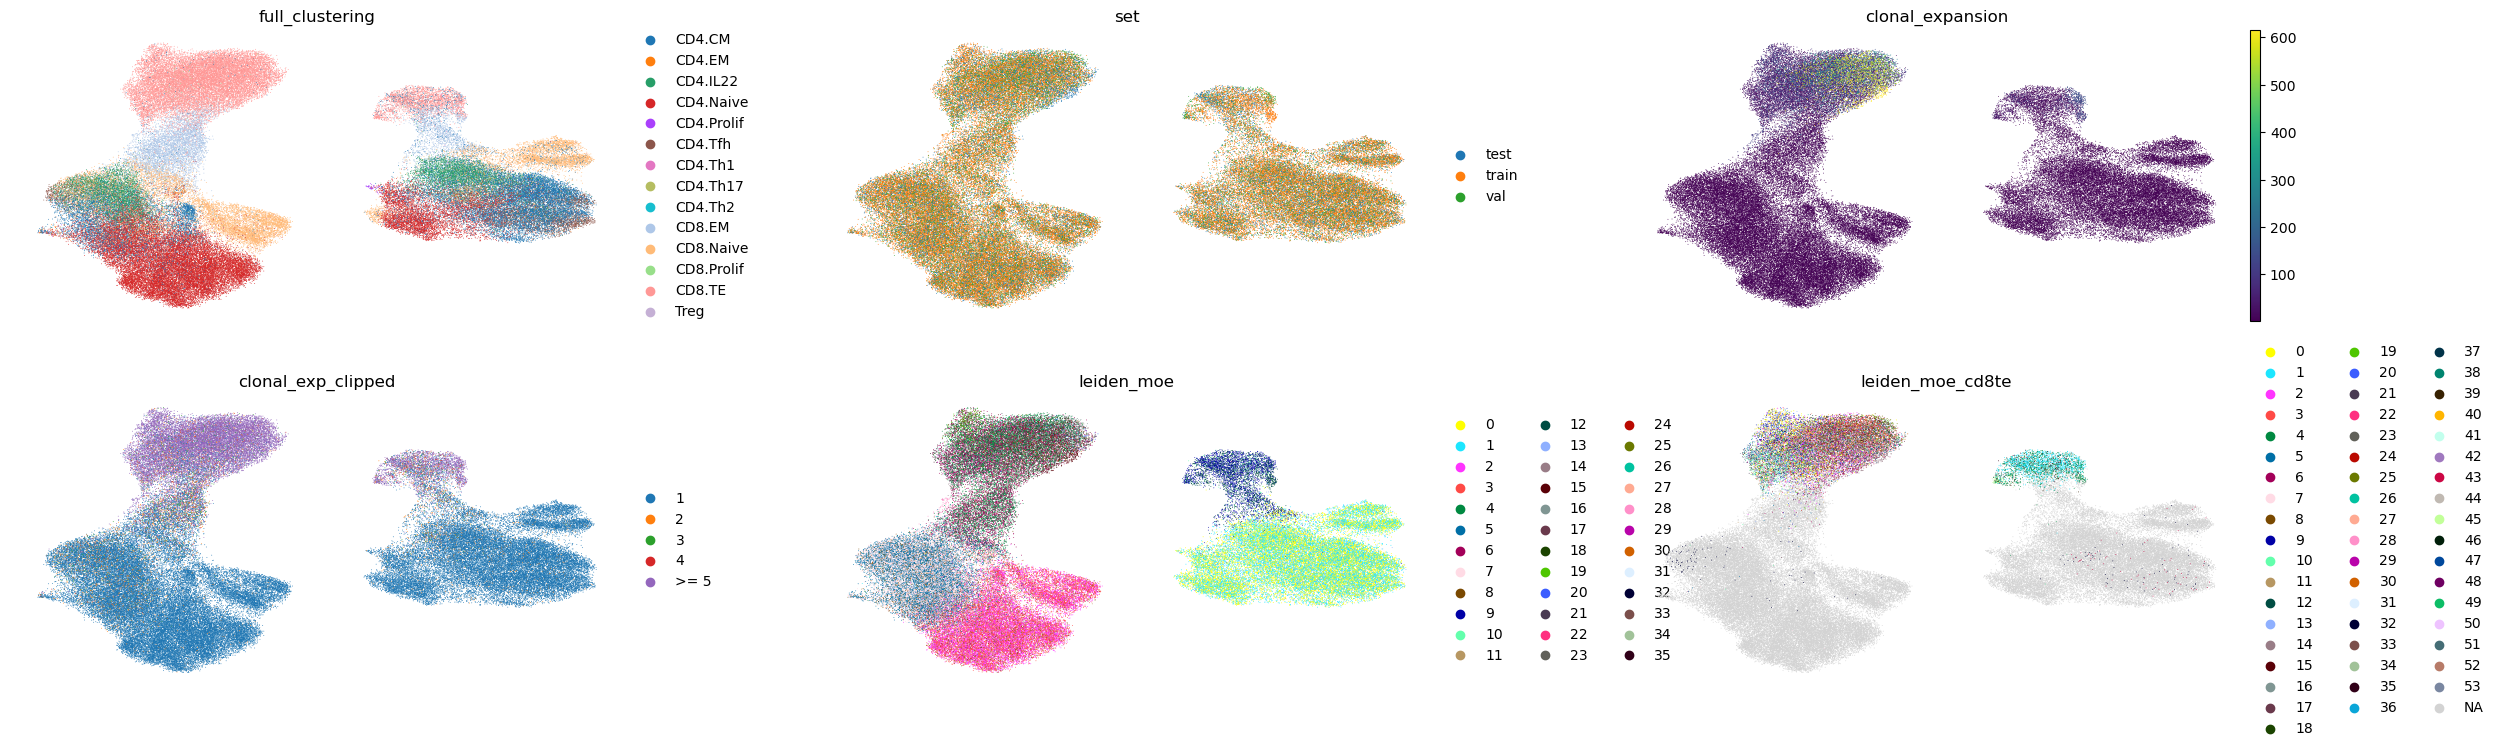

In [3]:
# distribution of important variables
sc.pl.embedding(data, basis='X_umap_moe', color=['full_clustering','set','clonal_expansion','clonal_exp_clipped', 'leiden_moe', 'leiden_moe_cd8te'], size=1.5, frameon=False, ncols=3, wspace=0.2)
sc.pl.embedding(data, basis='X_umap_rna', color=['full_clustering','set','clonal_expansion','clonal_exp_clipped', 'leiden_moe', 'leiden_moe_cd8te'], size=1.5, frameon=False, ncols=3, wspace=0.2)

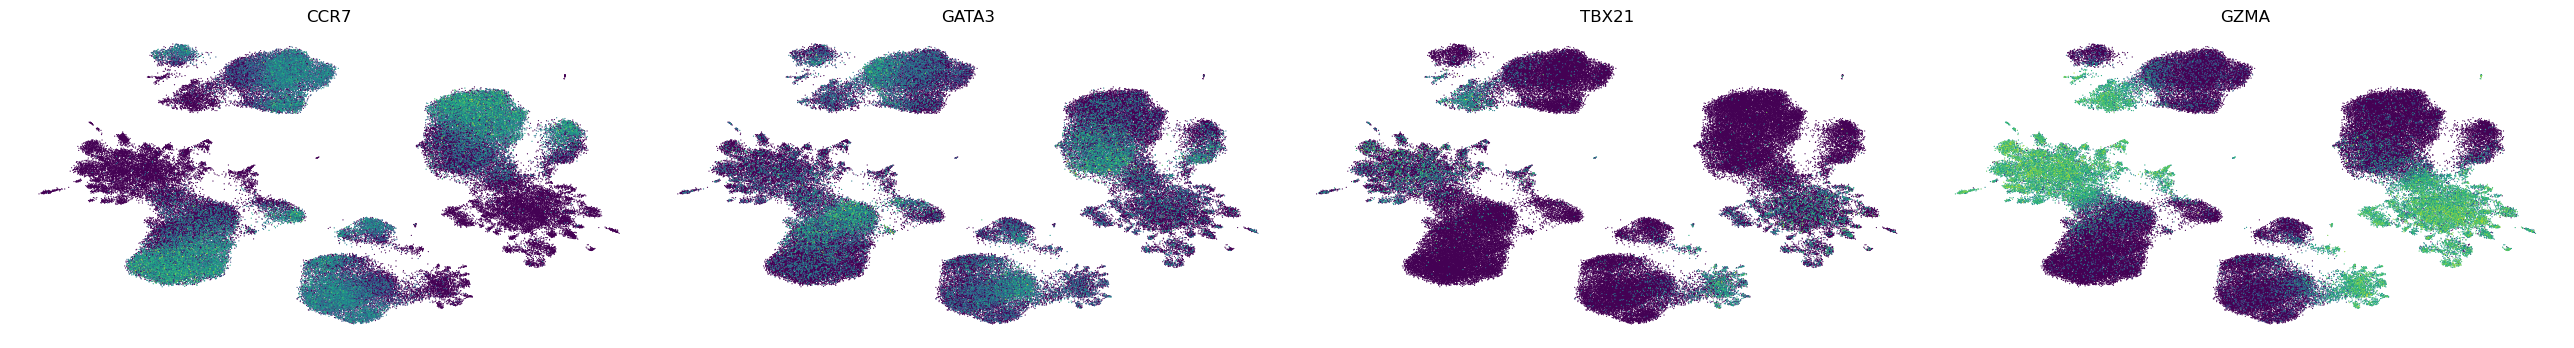

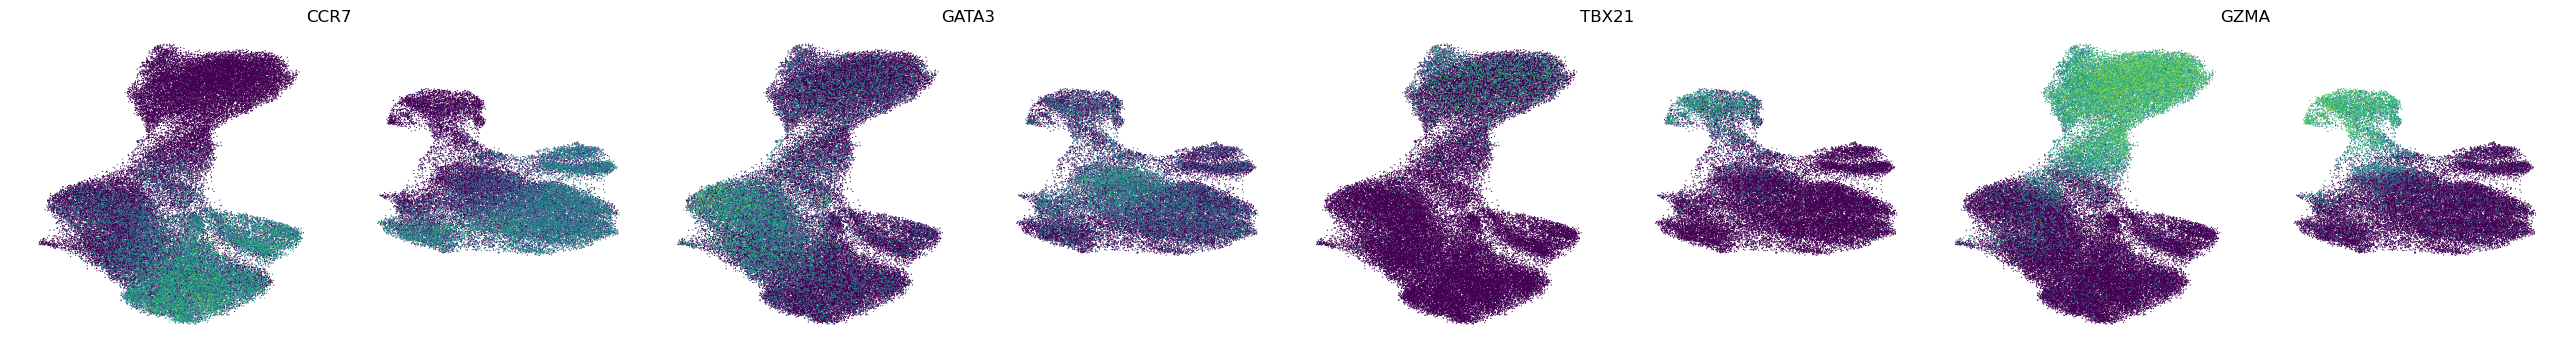

In [4]:
# conservation of important markers
markers=["CCR7",'GATA3', 'TBX21',"GZMA"]
sc.pl.embedding(data, basis='X_umap_moe', color=markers, size=3, frameon=False, ncols=4, wspace=0.001, colorbar_loc=None)
sc.pl.embedding(data, basis='X_umap_rna', color=markers, size=3, frameon=False, ncols=4, colorbar_loc=None, wspace=0.001)

# Cell type pure vs cell type diverse clones

In [5]:
# Calculate cell type purity per clone
plot_var = 'clonotype'
cluster_var = 'full_clustering'
props = data.obs.groupby([cluster_var, plot_var]).size().reset_index()
props = props.pivot(columns=plot_var, index=cluster_var).T
props.index = props.index.droplevel(0)
props.fillna(0, inplace=True)
total = props.sum(axis=1).values
props = props.div(total, axis=0)*100 
props['purity'] = props.max(axis=1)
props['total'] = total
props.index = props.index.astype(str)
props['dominating_cell'] = props.iloc[:,0:-2].idxmax(axis=1)
props.index = props.index.astype(str)
props[props.total>20].sort_values(by='purity', ascending=False, inplace=False)

full_clustering     CD4.CM  CD4.EM  CD4.IL22  CD4.Naive  CD4.Prolif  CD4.Tfh  \
clonotype                                                                      
0                 0.000000     0.0       0.0        0.0         0.0      0.0   
27130             0.000000     0.0       0.0        0.0         0.0      0.0   
33785             0.000000     0.0       0.0        0.0         0.0      0.0   
31762             0.000000     0.0       0.0        0.0         0.0      0.0   
30573             0.000000     0.0       0.0        0.0         0.0      0.0   
...                    ...     ...       ...        ...         ...      ...   
56764            18.518519     0.0       0.0        0.0         0.0      0.0   
24021             0.000000     0.0       0.0        0.0         0.0      0.0   
4799              0.000000     0.0       0.0        0.0         0.0      0.0   
38657             0.000000     0.0       0.0        0.0         0.0      0.0   
22502             0.000000     0.0       0.0        0.0         0.0      0.0   

full_clustering  CD4.Th1  CD4.Th17  CD4.Th2     CD8.EM  CD8.Naive  CD8.Prolif  \
clonotype                                                                       
0                    0.0       0.0      0.0   0.000000        0.0         0.0   
27130                0.0       0.0      0.0   0.000000        0.0         0.0   
33785                0.0       0.0      0.0   0.000000        0.0         0.0   
31762                0.0       0.0      0.0   0.000000        0.0         0.0   
30573                0.0       0.0      0.0   0.000000        0.0         0.0   
...                  ...       ...      ...        ...        ...         ...   
56764                0.0       0.0      0.0  55.555556        0.0         0.0   
24021                0.0       0.0      0.0  47.619048        0.0         0.0   
4799                 0.0       0.0      0.0  51.648352        0.0         0.0   
38657                0.0       0.0      0.0  50.000000        0.0         0.0   
22502                0.0       0.0      0.0  50.000000        0.0         0.0   

full_clustering      CD8.TE  Treg      purity  total dominating_cell  
clonotype                                                             
0                100.000000   0.0  100.000000     63          CD8.TE  
27130            100.000000   0.0  100.000000     42          CD8.TE  
33785            100.000000   0.0  100.000000     26          CD8.TE  
31762            100.000000   0.0  100.000000     24          CD8.TE  
30573            100.000000   0.0  100.000000     54          CD8.TE  
...                     ...   ...         ...    ...             ...  
56764             25.925926   0.0   55.555556     27          CD8.EM  
24021             52.380952   0.0   52.380952     21          CD8.TE  
4799              48.351648   0.0   51.648352     91          CD8.EM  
38657             50.000000   0.0   50.000000     30          CD8.EM  
22502             50.000000   0.0   50.000000     24          CD8.EM  

[222 rows x 17 columns]

In [6]:
# Define purest and most diverse clones among those with at least 20 cells
props['clone_type'] = np.nan
props = props.sort_values(by='total', ascending=False)
pure=props.loc[props.total > 20].sort_values(by='purity', ascending=False).head(10).index.tolist()
diverse=props.loc[props.total > 20].sort_values(by='purity', ascending=True).head(10).index.tolist()
props.loc[props.index.isin(pure),'clone_type'] = 'pure' 
props.loc[props.index.isin(diverse),'clone_type'] = 'diverse' 
ordered_categories = sum(zip(props.index[props.clone_type =='diverse'], props.index[props.clone_type =='pure']), ())
keep = props.index[props.clone_type.isin(['pure','diverse'])]
data.obs['clone_type'] = np.nan
data.obs['clone_type'][data.obs.clonotype.isin(keep)] = data.obs.clonotype[data.obs.clonotype.isin(keep)]
data.obs['clone_type'] = pd.Categorical(data.obs.clone_type, categories=ordered_categories)

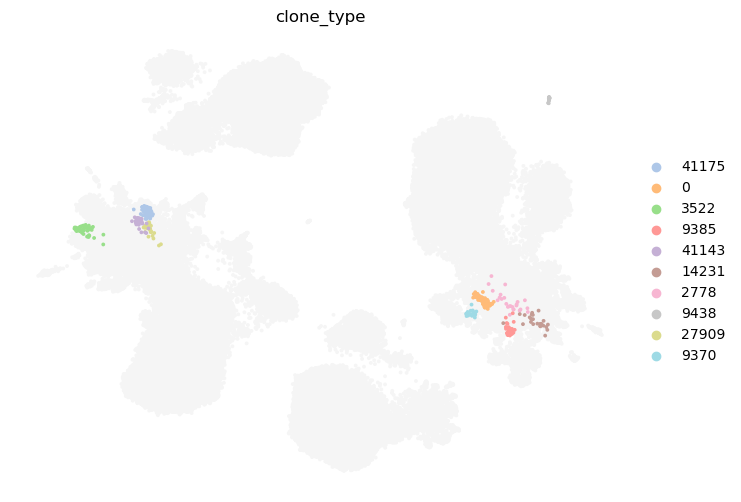

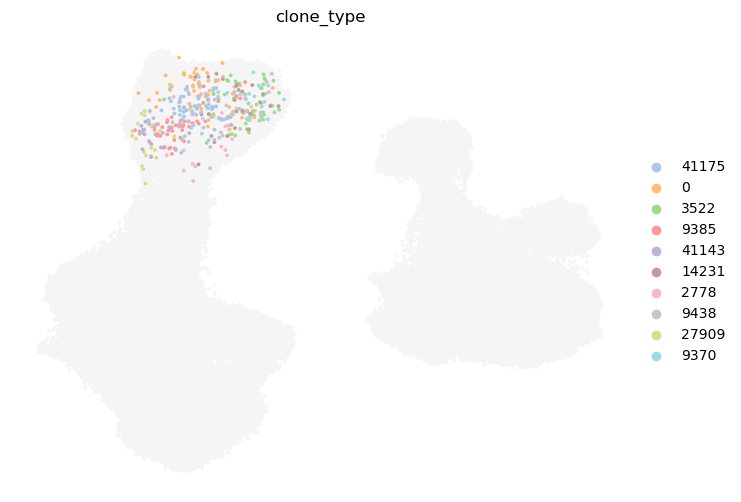

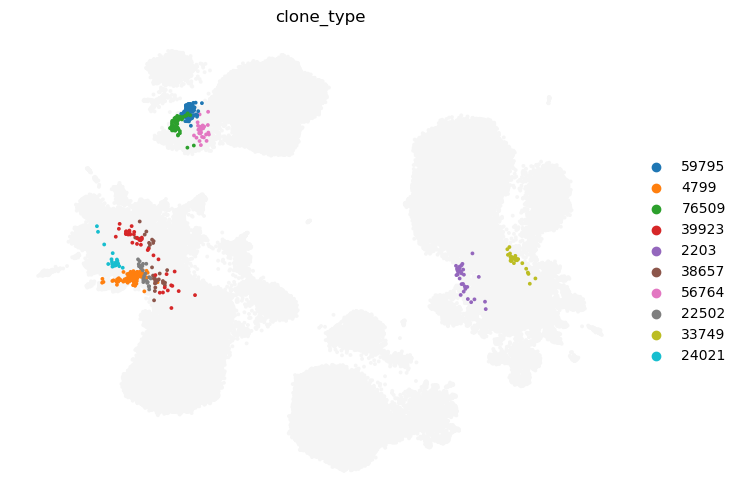

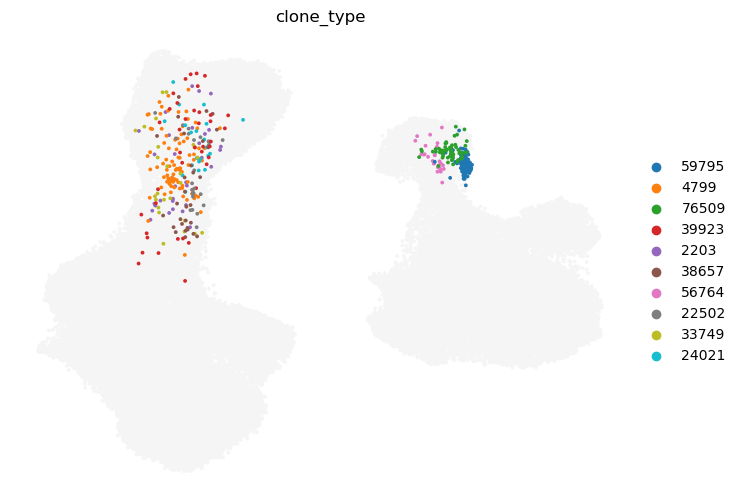

In [7]:
rcParams['figure.figsize'] = (8, 6)
sc.pl.embedding(data, basis='X_umap_moe', size=30, frameon=False, ncols=2, wspace=0.2, color=['clone_type'], groups=props.index[props.clone_type =='pure'].tolist(), na_in_legend=False, palette='tab20', na_color='whitesmoke')
sc.pl.embedding(data, basis='X_umap_rna', size=30, frameon=False, ncols=2, wspace=0.2, color=['clone_type'], groups=props.index[props.clone_type =='pure'].tolist(), na_in_legend=False, palette='tab20', na_color='whitesmoke')
sc.pl.embedding(data, basis='X_umap_moe', size=30, frameon=False, ncols=2, wspace=0.2, color=['clone_type'], groups=props.index[props.clone_type =='diverse'].tolist(), na_in_legend=False, palette='tab20', na_color='whitesmoke')
sc.pl.embedding(data, basis='X_umap_rna', size=30, frameon=False, ncols=2, wspace=0.2, color=['clone_type'], groups=props.index[props.clone_type =='diverse'].tolist(), na_in_legend=False, palette='tab20', na_color='whitesmoke')

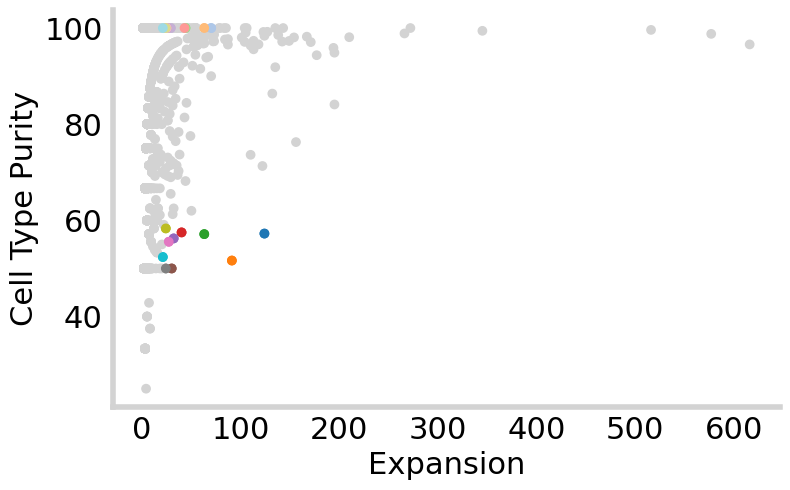

In [8]:
color_dict = {clone: color for clone, color in zip(ordered_categories, data.uns['clone_type_colors'])}
props['color'] = [color_dict[clone] if clone in color_dict else np.nan for clone in props.index]
props.loc[props.color.isna(),'color'] = 'lightgray'

rcParams['figure.figsize'] = (8, 5)
fig, ax = plt.subplots()
x=props.total
y=props.purity
ax.scatter(x, y, c=props.color)
ax.scatter(x[props.color!='lightgray'], y[props.color!='lightgray'], c=props[props.color!='lightgray'].color)
ax.set_xlabel('Expansion', fontsize=22)
ax.set_ylabel('Cell Type Purity', fontsize=22)
ax.tick_params(axis='both', labelsize=22)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.spines.bottom.set(color='lightgray',linewidth=4)
ax.spines.left.set(color='lightgray',linewidth=4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

fig.tight_layout()
plt.show()
rcParams['figure.figsize'] = (8, 4)

# Distance correlation

In [9]:
# model = utils.load_model(data, '/Users/irene.bonafonte/Documents/PhD/Software/mvTCR/saved_models/Haniffa/haniffa_tcr_moe_1.pt')
model = utils.load_model(data, 'saved_models/journal_2/haniffa/full/haniffa_tcr_moe_1.pt')
model = model.get_latent(data, metadata=[])
data.obsm['moe'] = model.X
del model
gc.collect()

16105

In [10]:
# keep only clonotypes with at least 20 cells
expanded_clonotypes = pd.DataFrame(index=data.obs.clonotype.value_counts().index[data.obs.clonotype.value_counts() > 20],columns=['rna_dist','moe_dist'])
expanded_mask = data.obs.clonotype.isin(expanded_clonotypes.index)

In [11]:
# compute rna (pca) and tcr distance between all cells/clones
distances = {}
distances['rna'] = metrics.pairwise_distances(data[expanded_mask].obsm['X_pca'])
distances['moe'] = metrics.pairwise_distances(data[expanded_mask].obsm['moe'])

In [12]:
for clone in expanded_clonotypes.index:
    for distance in ['rna','moe']:
        expanded_clonotypes.loc[clone, f'{distance}_dist'] = distances[distance][data[expanded_mask].obs.clonotype == clone,:][:,data[expanded_mask].obs.clonotype == clone].mean()
        
expanded_clonotypes['size'] = np.log(data.obs.clonotype.value_counts().values[data.obs.clonotype.value_counts() > 20])

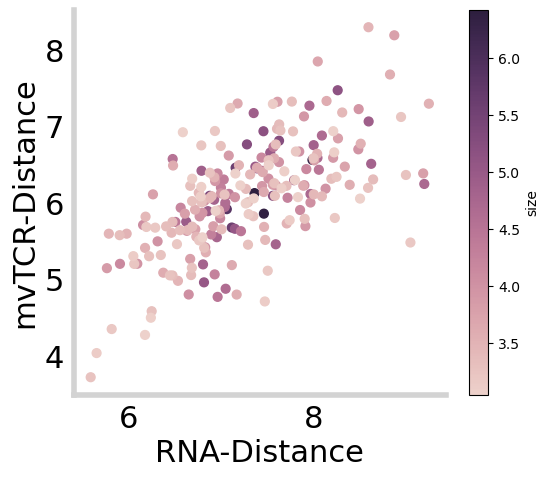

In [13]:
rcParams['figure.figsize'] = (6, 5)
ax = expanded_clonotypes.plot.scatter(x='rna_dist',y='moe_dist', c='size', colormap=sb.cubehelix_palette(as_cmap=True), s=40)
ax.set_xlabel('RNA-Distance', fontsize=22)
ax.set_ylabel('mvTCR-Distance', fontsize=22)
ax.tick_params(axis='both', labelsize=22)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
ax.spines.bottom.set(color='lightgray',linewidth=4)
ax.spines.left.set(color='lightgray',linewidth=4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
fig.tight_layout()
plt.show()
rcParams['figure.figsize'] = (8, 4)

In [14]:
import scipy.stats
r, pval = scipy.stats.pearsonr(expanded_clonotypes.rna_dist.values.astype(float),expanded_clonotypes.moe_dist.values.astype(float))
r, pval

(0.636063866782808, 1.4279020044612284e-26)